# Create a TensorFlow Model for hair detection

import the required packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import tensorflow as tf

Set the dataset path to the data directory with our tgz file. These images were taken from Google image searches .

In [2]:
dataset_path = 'file://' + os.path.join(os.getcwd(), 'data', 'hairtypes.tgz')

load and extract data from tgz into TensorFlow cache.

In [3]:
archive = tf.keras.utils.get_file(origin=dataset_path, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

Let's look at how many images our dataset contains.

In [4]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

357


In [5]:
batch_size = 32
img_height = 180
img_width = 180

Let's create our training dataset. We use 80% of our data for training. The other 20% is used for validation.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names

Found 353 files belonging to 4 classes.
Using 283 files for training.


2023-04-02 20:03:31.302306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 353 files belonging to 4 classes.
Using 70 files for validation.


Normalize the data. We want to keep values between 0 and 1. Therefore we rescale the RGB channels which range from 0 to 255 to standardize values between 0 and 1. This means 0 will be 0 and 255 will be 1.

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Performance tuning our dataset. When we are fitting our model the images will be kept in memory after being loaded off disk during the first epoch. Reading from memory is much faster than reading from disk.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Compile the model

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Train the model

In [13]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 6s 514ms/step - loss: 1.2915 - accuracy: 0.3534 - val_loss: 1.1747 - val_accuracy: 0.4143
Epoch 2/10
9/9 [==============================] - 4s 453ms/step - loss: 1.0430 - accuracy: 0.4735 - val_loss: 1.1710 - val_accuracy: 0.4571
Epoch 3/10
9/9 [==============================] - 4s 440ms/step - loss: 0.9043 - accuracy: 0.5972 - val_loss: 1.0074 - val_accuracy: 0.7143
Epoch 4/10
9/9 [==============================] - 4s 443ms/step - loss: 0.7977 - accuracy: 0.6537 - val_loss: 0.9319 - val_accuracy: 0.6714
Epoch 5/10
9/9 [==============================] - 4s 443ms/step - loss: 0.7162 - accuracy: 0.7138 - val_loss: 0.8992 - val_accuracy: 0.6571
Epoch 6/10
9/9 [==============================] - 4s 444ms/step - loss: 0.6557 - accuracy: 0.7067 - val_loss: 1.0658 - val_accuracy: 0.6000
Epoch 7/10
9/9 [==============================] - 4s 440ms/step - loss: 0.7885 - accuracy: 0.6219 - val_loss: 0.8400 - val_accuracy: 0.7000
Epoch 8/10
9/9 [====

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

Let's graph some of the accuracy metrics to see how our model is performing. Looks like Training and Validation accuracy follow a similar trend.

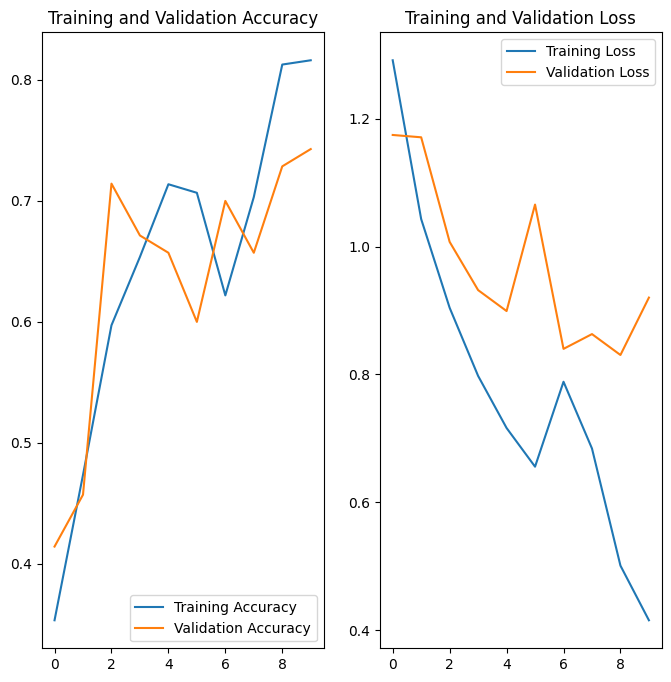

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
img = tf.keras.utils.load_img('IG-straight.jpeg', target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 207ms/step
This image most likely belongs to straight with a 99.25 percent confidence.


In [17]:
model.save('hairtypesmodel')

INFO:tensorflow:Assets written to: hairtypesmodel/assets


INFO:tensorflow:Assets written to: hairtypesmodel/assets
